In [31]:
import pandas as pd
import numpy as np 
from sklearn.datasets import load_files

# Text cleaning and preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from tqdm.notebook import tqdm

In [32]:
df = pd.read_csv("./spam/train.csv")
df.shape

(30344, 3)

In [33]:
30344/500

60.688

In [34]:
len(df)

30344

In [35]:
df.head()

,Subject,Message,Spam/Ham
0,transfers from ees,attached is the latest version of the cost cen...,spam
1,fw : re ivanhoe e . s . d,"fyi , kim .\n- - - - - original message - - - ...",spam
2,re : enerfin meter 980439 for 10 / 00,it did but tetco prorated the flow between the...,ham
3,meoh plant status,the methanol plant has determined extensive re...,ham
4,re : tenaska iv,i tried calling you this am but your phone rol...,spam


In [36]:
df.head()

,Subject,Message,Spam/Ham
0,transfers from ees,attached is the latest version of the cost cen...,spam
1,fw : re ivanhoe e . s . d,"fyi , kim .\n- - - - - original message - - - ...",spam
2,re : enerfin meter 980439 for 10 / 00,it did but tetco prorated the flow between the...,ham
3,meoh plant status,the methanol plant has determined extensive re...,ham
4,re : tenaska iv,i tried calling you this am but your phone rol...,spam


Now we have list of texts, that encoded binary. Using 'decode' is one of possible solutions, but some texts don't allow us to apply decoding. This can be solved by deleting these texts, but because of this, we can lose important information. Instead of this we can do following:

* We should remove all special symbols.
* Remove 'b' in beginning of each text
* Replace all gaps (\t, \n, \r, \f) between words with spaces
* Remove all non-letters characters

Trying Naive Bayes model as the likelihood of whether an email is spam or ham is an aposterior probability and they usually show high performance in spam detection.

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.feature_extraction.text import HashingVectorizer

model = MultinomialNB()

#tf = TfidfVectorizer()
hvec = HashingVectorizer(n_features=2**9,alternate_sign=False) #***change this logically***

def preProcess(X):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    corpus = []
    for i in tqdm(range(0, len(X))):
        # Remove special symbols
        review = re.sub(r'\\r\\n', ' ', str(X[i]))
        # Remove all symbols except letters
        review = re.sub('[^a-zA-Z]', ' ', review)
        # Replacing all gaps with spaces 
        review = re.sub(r'\s+', ' ', review)                    
        # Remove 'b' in the beginning of each text
        review = re.sub(r'^b\s+', '', review)       

        review = review.lower().split()
        review = [stemmer.stem(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    
    # Creating the Bag of Words model
    # cv = CountVectorizer() # Should this be global?
    #X = cv.fit_transform(corpus).toarray()
    # return cv.fit_transform(corpus).toarray()
    X = hvec.fit_transform(corpus)
    print(X)
    return X.toarray()

def trainBatch(X, y):
    X = preProcess(X)

    # Splitting data on train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=9, test_size=0.2)
    
    global model
    model = model.partial_fit(X_train, y_train, np.unique(y))
    pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, pos_label = 'spam')
    recall = recall_score(y_test, pred, pos_label = 'spam')
    conf_m = confusion_matrix(y_test, pred)

    print(f"accuracy: %.3f" %accuracy)
    print(f"precision: %.3f" %precision)
    print(f"recall: %.3f" %recall)
    print(f"confusion matrix: ")
    print(conf_m)

    return accuracy, precision, recall


```
accuracy: 0.979
precision: 0.962
recall: 1.000
confusion matrix: 
[[452  21]
 [  0 527]]
```

In [38]:
def makeBatch(df, batchSize = 500):
    for i in range(len(df)//500):
        X, y = df['Message'][i:i + batchSize + 1], df['Spam/Ham'][i:i + batchSize + 1]
        X.index = range(batchSize + 1)
        y.index = range(batchSize + 1)
        yield X, y

In [39]:
df["Message"][0:300]

0      attached is the latest version of the cost cen...
1      fyi , kim .\n- - - - - original message - - - ...
2      it did but tetco prorated the flow between the...
3      the methanol plant has determined extensive re...
4      i tried calling you this am but your phone rol...
                             ...                        
295    fyi , kim .\n- - - - - original message - - - ...
296    fyi , kim .\n- - - - - original message - - - ...
297    mark ,\nfirst let me say thank you for your as...
298    start date : 12 / 17 / 01 ; hourahead hour : 1...
299    yesterday we sold to santa clara ( silicon val...
Name: Message, Length: 300, dtype: object

In [40]:
df['Spam/Ham'][0:300]

0      spam
1      spam
2       ham
3       ham
4      spam
       ... 
295    spam
296    spam
297     ham
298     ham
299     ham
Name: Spam/Ham, Length: 300, dtype: object

In [41]:
batch = makeBatch(df)

In [42]:
type(next(batch)[0])

pandas.core.series.Series

In [43]:
NBatches = 5

In [44]:
def tester(X,y):
    print(X)
    print(y)

tester(*next(batch))

0      fyi , kim .\n- - - - - original message - - - ...
1      it did but tetco prorated the flow between the...
2      the methanol plant has determined extensive re...
3      i tried calling you this am but your phone rol...
4      fyi , kim .\n- - - - - original message - - - ...
                             ...                        
496    louise ,\nthanks so much for your speedy reply...
497    michelle :\nok we are all set up . we are goin...
498    fyi , see terry ' s note\n- - - - - - - - - - ...
499    the enron building is being evacuated . howeve...
500    attached is the latest version of the cost cen...
Name: Message, Length: 501, dtype: object
0      spam
1       ham
2       ham
3      spam
4      spam
       ... 
496    spam
497     ham
498     ham
499     ham
500    spam
Name: Spam/Ham, Length: 501, dtype: object


In [45]:
metrics = ('accuracy', 'precision', 'recall')
history = {metric : [] for metric in metrics}
for batchNum in range(NBatches):
    print(f"------------------------ Batch {batchNum + 1} ------------------------")

    print("*********")
    X,y = next(batch)
    print(X.shape)
    print(len(X[0]),len(X[1]),len(X[2]))
    print(y.shape)
    print("*********")

    scores = trainBatch(X,y)
    for i in range(len(metrics)):
        history[metrics[i]].append(scores[i])
    print("---------------------------------------------------------")

------------------------ Batch 1 ------------------------
*********
(501,)
4512 360 2284
(501,)
*********


  0%|          | 0/501 [00:00<?, ?it/s]

  (0, 0)	0.02876879013347354
  (0, 1)	0.01438439506673677
  (0, 4)	0.01438439506673677
  (0, 13)	0.12945955560063094
  (0, 16)	0.01438439506673677
  (0, 23)	0.02876879013347354
  (0, 25)	0.1438439506673677
  (0, 27)	0.02876879013347354
  (0, 31)	0.07192197533368384
  (0, 42)	0.01438439506673677
  (0, 48)	0.11507516053389416
  (0, 53)	0.01438439506673677
  (0, 60)	0.01438439506673677
  (0, 63)	0.01438439506673677
  (0, 72)	0.01438439506673677
  (0, 74)	0.02876879013347354
  (0, 83)	0.01438439506673677
  (0, 89)	0.01438439506673677
  (0, 92)	0.01438439506673677
  (0, 97)	0.01438439506673677
  (0, 102)	0.02876879013347354
  (0, 106)	0.01438439506673677
  (0, 109)	0.01438439506673677
  (0, 115)	0.15822834573410446
  (0, 122)	0.01438439506673677
  :	:
  (500, 257)	0.17213259316477408
  (500, 272)	0.08606629658238704
  (500, 273)	0.08606629658238704
  (500, 279)	0.34426518632954817
  (500, 294)	0.08606629658238704
  (500, 297)	0.08606629658238704
  (500, 300)	0.08606629658238704
  (500, 308)

  0%|          | 0/501 [00:00<?, ?it/s]

  (0, 13)	0.16666666666666666
  (0, 20)	0.16666666666666666
  (0, 29)	0.16666666666666666
  (0, 32)	0.16666666666666666
  (0, 44)	0.16666666666666666
  (0, 81)	0.16666666666666666
  (0, 92)	0.16666666666666666
  (0, 98)	0.16666666666666666
  (0, 106)	0.16666666666666666
  (0, 107)	0.16666666666666666
  (0, 108)	0.3333333333333333
  (0, 145)	0.16666666666666666
  (0, 253)	0.16666666666666666
  (0, 259)	0.16666666666666666
  (0, 273)	0.16666666666666666
  (0, 279)	0.16666666666666666
  (0, 294)	0.16666666666666666
  (0, 310)	0.5
  (0, 361)	0.16666666666666666
  (0, 366)	0.16666666666666666
  (0, 371)	0.16666666666666666
  (0, 385)	0.16666666666666666
  (0, 393)	0.16666666666666666
  (0, 410)	0.16666666666666666
  (0, 477)	0.16666666666666666
  :	:
  (500, 363)	0.060302268915552716
  (500, 368)	0.060302268915552716
  (500, 369)	0.18090680674665816
  (500, 370)	0.060302268915552716
  (500, 371)	0.060302268915552716
  (500, 374)	0.18090680674665816
  (500, 375)	0.12060453783110543
  (500, 3

  0%|          | 0/501 [00:00<?, ?it/s]

  (0, 0)	0.043314808182421
  (0, 5)	0.129944424547263
  (0, 6)	0.043314808182421
  (0, 9)	0.043314808182421
  (0, 23)	0.043314808182421
  (0, 27)	0.086629616364842
  (0, 28)	0.086629616364842
  (0, 31)	0.086629616364842
  (0, 34)	0.043314808182421
  (0, 37)	0.043314808182421
  (0, 38)	0.043314808182421
  (0, 47)	0.086629616364842
  (0, 50)	0.043314808182421
  (0, 52)	0.043314808182421
  (0, 53)	0.043314808182421
  (0, 57)	0.043314808182421
  (0, 58)	0.129944424547263
  (0, 63)	0.043314808182421
  (0, 65)	0.043314808182421
  (0, 66)	0.043314808182421
  (0, 82)	0.086629616364842
  (0, 83)	0.043314808182421
  (0, 84)	0.086629616364842
  (0, 91)	0.043314808182421
  (0, 104)	0.043314808182421
  :	:
  (500, 335)	0.045501575519329006
  (500, 344)	0.09100315103865801
  (500, 353)	0.09100315103865801
  (500, 355)	0.273009453115974
  (500, 358)	0.09100315103865801
  (500, 359)	0.045501575519329006
  (500, 369)	0.31851102863530306
  (500, 380)	0.09100315103865801
  (500, 403)	0.045501575519329006

  0%|          | 0/501 [00:00<?, ?it/s]

  (0, 4)	0.07273929674533079
  (0, 13)	0.14547859349066158
  (0, 24)	0.07273929674533079
  (0, 25)	0.07273929674533079
  (0, 26)	0.07273929674533079
  (0, 37)	0.07273929674533079
  (0, 40)	0.14547859349066158
  (0, 46)	0.07273929674533079
  (0, 51)	0.29095718698132317
  (0, 59)	0.07273929674533079
  (0, 60)	0.07273929674533079
  (0, 63)	0.21821789023599236
  (0, 75)	0.07273929674533079
  (0, 78)	0.14547859349066158
  (0, 79)	0.14547859349066158
  (0, 91)	0.07273929674533079
  (0, 99)	0.07273929674533079
  (0, 100)	0.21821789023599236
  (0, 102)	0.07273929674533079
  (0, 127)	0.07273929674533079
  (0, 130)	0.07273929674533079
  (0, 141)	0.14547859349066158
  (0, 163)	0.07273929674533079
  (0, 166)	0.14547859349066158
  (0, 176)	0.07273929674533079
  :	:
  (500, 279)	0.09205746178983235
  (500, 283)	0.1841149235796647
  (500, 292)	0.09205746178983235
  (500, 304)	0.09205746178983235
  (500, 307)	0.09205746178983235
  (500, 309)	0.09205746178983235
  (500, 318)	0.09205746178983235
  (500,

  0%|          | 0/501 [00:00<?, ?it/s]

  (0, 0)	0.060302268915552716
  (0, 6)	0.060302268915552716
  (0, 9)	0.060302268915552716
  (0, 18)	0.060302268915552716
  (0, 20)	0.060302268915552716
  (0, 24)	0.24120907566221086
  (0, 27)	0.060302268915552716
  (0, 32)	0.060302268915552716
  (0, 37)	0.060302268915552716
  (0, 38)	0.060302268915552716
  (0, 43)	0.060302268915552716
  (0, 44)	0.060302268915552716
  (0, 46)	0.12060453783110543
  (0, 52)	0.18090680674665816
  (0, 54)	0.060302268915552716
  (0, 55)	0.060302268915552716
  (0, 63)	0.3015113445777636
  (0, 65)	0.060302268915552716
  (0, 72)	0.060302268915552716
  (0, 75)	0.060302268915552716
  (0, 83)	0.18090680674665816
  (0, 88)	0.12060453783110543
  (0, 91)	0.060302268915552716
  (0, 98)	0.060302268915552716
  (0, 100)	0.12060453783110543
  :	:
  (500, 187)	0.07273929674533079
  (500, 197)	0.14547859349066158
  (500, 213)	0.07273929674533079
  (500, 222)	0.07273929674533079
  (500, 254)	0.07273929674533079
  (500, 265)	0.4364357804719847
  (500, 297)	0.07273929674533079

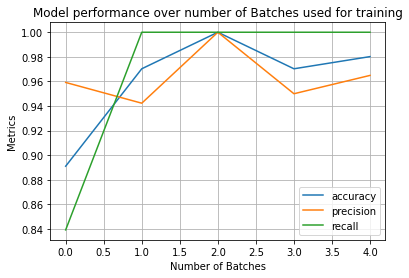

In [47]:
import matplotlib.pyplot as plt
for metric in metrics:
    plt.plot(history[metric], label = metric)

plt.legend()
plt.grid()
plt.ylabel('Metrics')
plt.xlabel('Number of Batches')
plt.title('Model performance over number of Batches used for training')
plt.show()